# Setting up environment and importing modules

In [77]:

%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
#os.environ["BART_TOOLBOX_PATH"] = "/home/usr/razzaquer/Desktop/ese5934_project/ese5934_project/bart"
#"/Users/chunxuguo/bart"
import torch
import torchopt
from einops import rearrange, reduce# Array manipulation
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel,F_adj
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create a mask function

In [2]:

mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[1])




# The `data_transform` function takes raw MRI data (`kspace`, `mask`) as input, applies normalization and undersampling, 
# estimates coil sensitivity maps, and returns the processed data in a format suitable for use in MRI reconstruction tasks.

In [4]:


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm




# Extracting the Data

In [5]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path("/home/usr/razzaquer/Desktop/ese5934_project/Main Data"),
    transform=data_transform,
    challenge="multicoil",
)

In [6]:
# Check the data type of the dataset object

dataset_type = type(dataset)
print("Dataset Type:", dataset_type)
len(dataset)

Dataset Type: <class 'fastmri.data.mri_data.SliceDataset'>


33

In [7]:
# Access contents in the dataset

#for data in dataset:
    #print(data)  # Assuming each element of the dataset is printed


In [8]:
#Accessing all elements

first_element = dataset[0]  
print("First Element:", first_element)

tensor([[[5.0087e-05, 1.3522e-04]]]) tensor([[[0.2028, 0.2027]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.
First Element: (tensor([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         ...,

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
         

In [9]:
#Accessing any one element 

TUP1=dataset[2]
len(TUP1) #Any one element is a tuple, with 5 elements, among them 1 is a tuple, and rest 4 are tensors, among them 3 have the dimension torch.Size([15, 640, 368, 2]), and 1 has dimension ([1,1,368,1]) 

tensor([[[0.0008, 0.0007]]]) tensor([[[0.6448, 0.6412]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


5

In [11]:
# Access the tuple


# Extract each element of the tuple
element1 = TUP1[0]
element2 = TUP1[1]
element3 =TUP1[2]
element4 =TUP1[3]
element5 = TUP1[4]

# Print or use each extracted element as needed
print("Element 1:", element5)


Element 1: tensor([[[[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., 0.]],

         [[0., -0.],
          [0., -0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., -0.]],

         ...,

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., -0.],
          [0., -0.]]],


        [[[0., -0.],
          [0., -0.],
          [0., -0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0

In [12]:
element4.shape
#len(element2)
"In MRI, k-space data with multiple coils often arises from parallel imaging techniques, where multiple receiver coils are used to acquire data simultaneously. Each coil captures a portion of the k-space data independently, allowing for faster acquisition and improved signal-to-noise ratio."

"Given that your k-space data has 15 coils, the first dimension of the tensor with size 15 likely represents each coil. Therefore, the shape `[15, 640, 368, 2]` can be interpreted as follows:"

"- 15: Number of coils."
"- 640: Number of samples along the frequency encoding direction."
"- 368: Number of samples along the phase encoding direction."
"- 2: Complex values (real and imaginary parts) for each data point."

"This shape suggests that you have k-space data acquired from 15 coils, where each coil's data is represented as a 2D array with dimensions `640 x 368` and each data point contains complex values."

"If you have any further questions or need additional clarification, please feel free to ask!"



'If you have any further questions or need additional clarification, please feel free to ask!'

In [13]:
# Reading hdF5 file in general
import h5py

# Open the HDF5 file
with h5py.File('/home/usr/razzaquer/Desktop/ese5934_project/Main Data/file1002570.h5', 'r') as f:
    # List all datasets in the file
    print("Datasets in the HDF5 file:", list(f.keys()))
    # Access a specific dataset (replace 'dataset_name' with the actual dataset name)
    dataset_name = 'kspace'
    dataset = f[dataset_name]

    # Read data from the dataset
    data = dataset[()]  # This reads the entire dataset into a NumPy array

    # Access attributes of the dataset
    attributes = dataset.attrs  # This gets all the attributes associated with the dataset

    # Print dataset shape and attributes
    print("Dataset shape:", data.shape)
    print("Dataset attributes:", attributes)



    

Datasets in the HDF5 file: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Dataset shape: (33, 15, 640, 368)
Dataset attributes: <Attributes of HDF5 object at 140032909604560>


# Grid Field (Voxel Representation)

In [14]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path("/home/usr/razzaquer/Desktop/ese5934_project/Main Data"),
    transform=data_transform,
    challenge="multicoil",
)



#This code is setting up the optimization process for MRI reconstruction, initializing an optimizer, 
#retrieving relevant data from the dataset, and preparing a Grid object for further processing.


#The Grid module represents a trainable grid parameter that can be used as part of a neural network model in PyTorch. 

from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.001)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]# Take any data from 1--33
field = Grid((640, 368), mean, std)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [15]:
print(kspace.shape,masked_kspace.shape, mask.shape, csm.shape)

#mask.shape: This tensor has a shape of (1, 1, 368, 1).

#The first dimension (1) suggests that there is only one mask in the dataset.
#The second dimension (1) indicates that there is only one channel in the mask.
#The third dimension (368) represents the number of columns in the mask.
#The fourth dimension (1) suggests that there is only one value associated with each column in the mask

torch.Size([15, 640, 368, 2]) torch.Size([15, 640, 368, 2]) torch.Size([1, 1, 368, 1]) torch.Size([15, 640, 368, 2])


# Reconstruction: ADAM Optimizer

In [61]:
params, image_list_ADAM= reconstruct(
    field,
    torch.rand(1, 2), #tensor([[0.9300, 0.4349]])                
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=400,#8000
    device=torch.device("cpu"),
)#device=torch.device("cuda")--Try to use it for my server--x should be the inverse fourier transform of y for the initialization

iteration 1, dc_loss: 2.280045509338379, tv_loss: 0.003044404089450836
iteration 2, dc_loss: 2.2795867919921875, tv_loss: 0.003050396451726556
iteration 3, dc_loss: 2.279128074645996, tv_loss: 0.0030528546776622534
iteration 4, dc_loss: 2.2786693572998047, tv_loss: 0.003054350847378373
iteration 5, dc_loss: 2.2782111167907715, tv_loss: 0.0030567487701773643
iteration 6, dc_loss: 2.27775239944458, tv_loss: 0.003060135990381241
iteration 7, dc_loss: 2.277294397354126, tv_loss: 0.0030628680251538754
iteration 8, dc_loss: 2.276836395263672, tv_loss: 0.003065257566049695
iteration 9, dc_loss: 2.2763781547546387, tv_loss: 0.0030680526979267597
iteration 10, dc_loss: 2.2759203910827637, tv_loss: 0.0030709148850291967
iteration 11, dc_loss: 2.2754626274108887, tv_loss: 0.0030736641492694616
iteration 12, dc_loss: 2.2750048637390137, tv_loss: 0.0030763670802116394
iteration 13, dc_loss: 2.274547576904297, tv_loss: 0.0030790995806455612
iteration 14, dc_loss: 2.274090051651001, tv_loss: 0.003081

In [63]:
type(image_list_ADAM)
len(image_list_ADAM)

list

In [64]:
# Applicable for 20 images from 200 iterations 
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 1x4
#fig, axs = plt.subplots(1, 4, figsize=(20, 10))
#for i, image in enumerate(image_list):
    #axs[i % 5].imshow(complex_abs(image), cmap="gray")

In [65]:
'''import matplotlib.pyplot as plt

# there are 160 images in the list,
# we want to plot them in a grid of 16x10 (20x8,replace 10 by 8, make figsize= (16,20))
fig, axs = plt.subplots(16, 10, figsize=(20, 20))
for i, image in enumerate(image_list_ADAM):
    row_idx = i // 10
    col_idx = i % 10
    axs[row_idx, col_idx].imshow(complex_abs(image), cmap="gray")
#plt.show()'''

'import matplotlib.pyplot as plt\n\n# there are 160 images in the list,\n# we want to plot them in a grid of 16x10 (20x8,replace 10 by 8, make figsize= (16,20))\nfig, axs = plt.subplots(16, 10, figsize=(20, 20))\nfor i, image in enumerate(image_list_ADAM):\n    row_idx = i // 10\n    col_idx = i % 10\n    axs[row_idx, col_idx].imshow(complex_abs(image), cmap="gray")\n#plt.show()'

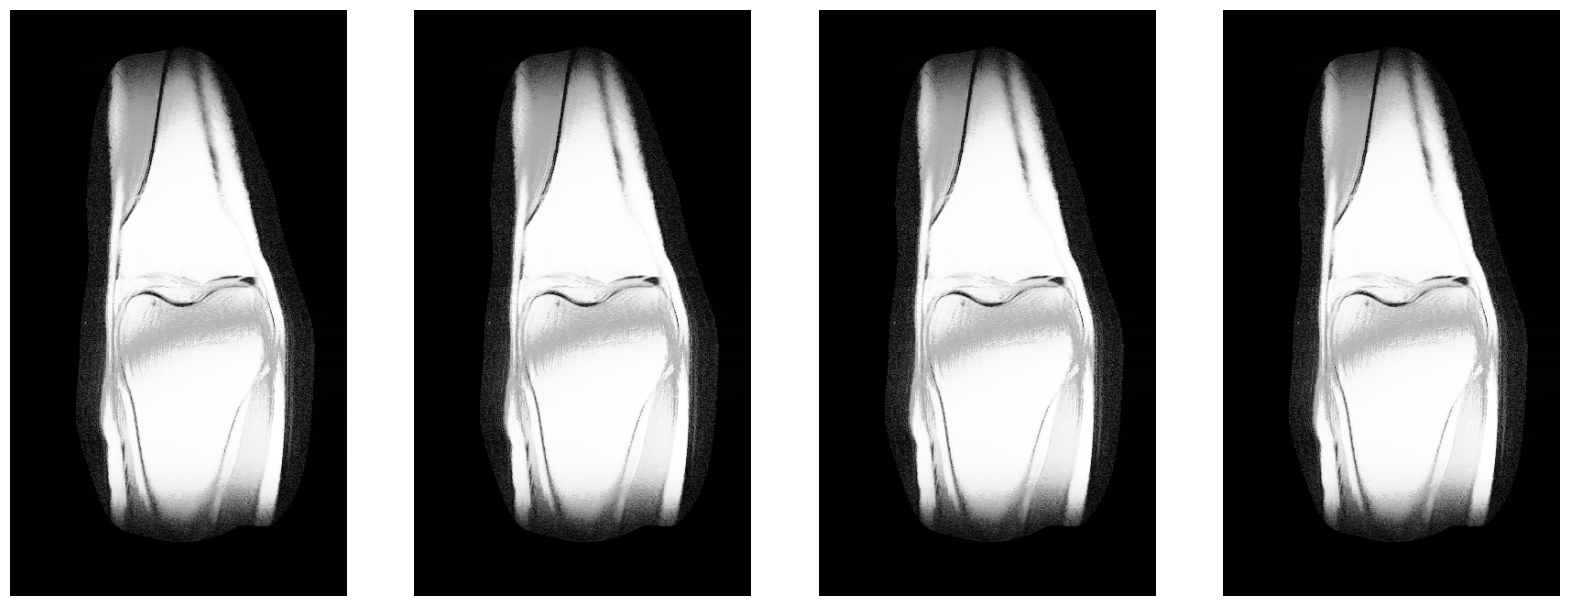

In [67]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list_ADAM[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")  # , vmin=0, vmax=2)
    axs[i % 5].axis("off")

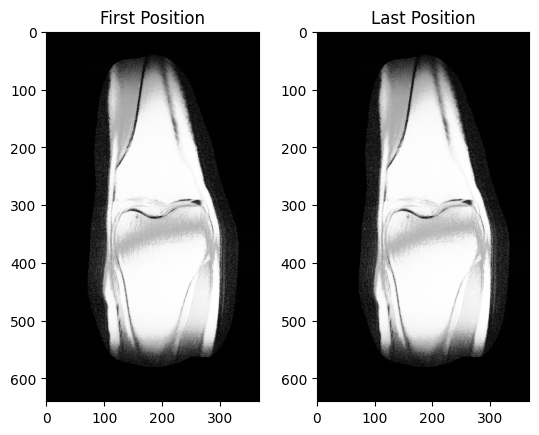

In [69]:
import matplotlib.pyplot as plt

# Plot the first figure of index 0
plt.subplot(1, 2, 1)
plt.imshow(complex_abs(image_list_ADAM[0]), cmap="gray")
#plt.title("Index 0")
plt.title("First Position")

# Plot the last figure of index 159
plt.subplot(1, 2, 2)
plt.imshow(complex_abs(image_list_ADAM[-1]), cmap="gray")
#plt.title("Index 159")
plt.title("Last Position")

plt.show()


In [72]:
'''import random
import matplotlib.pyplot as plt

# Randomly select 20 indices from 0 to 159
random_indices =sorted(random.sample(range(160), 20))

# Plot the randomly selected images
fig, axs = plt.subplots(4, 5, figsize=(10, 10))

# Flatten the axs array to easily access each subplot
axs = axs.flatten()

# Plot each randomly selected image
for i, index in enumerate(random_indices):
    image = image_list_ADAM[index]
    axs[i].imshow(complex_abs(image), cmap="gray")
    axs[i].set_title(f"Image {index+1}")  # Set title for each subplot

# Hide any remaining empty subplots
#for j in range(20, 4 * 5):
    #axs[j].axis("off")

plt.tight_layout()
plt.show()'''


'import random\nimport matplotlib.pyplot as plt\n\n# Randomly select 20 indices from 0 to 159\nrandom_indices =sorted(random.sample(range(160), 20))\n\n# Plot the randomly selected images\nfig, axs = plt.subplots(4, 5, figsize=(10, 10))\n\n# Flatten the axs array to easily access each subplot\naxs = axs.flatten()\n\n# Plot each randomly selected image\nfor i, index in enumerate(random_indices):\n    image = image_list_ADAM[index]\n    axs[i].imshow(complex_abs(image), cmap="gray")\n    axs[i].set_title(f"Image {index+1}")  # Set title for each subplot\n\n# Hide any remaining empty subplots\n#for j in range(20, 4 * 5):\n    #axs[j].axis("off")\n\nplt.tight_layout()\nplt.show()'

# SIREN

In [73]:
coords = get_coordinates(size)

In [74]:
print(coords)

tensor([[[-1.0000, -1.0000],
         [-1.0000, -0.9946],
         [-1.0000, -0.9891],
         ...,
         [-1.0000,  0.9891],
         [-1.0000,  0.9946],
         [-1.0000,  1.0000]],

        [[-0.9969, -1.0000],
         [-0.9969, -0.9946],
         [-0.9969, -0.9891],
         ...,
         [-0.9969,  0.9891],
         [-0.9969,  0.9946],
         [-0.9969,  1.0000]],

        [[-0.9937, -1.0000],
         [-0.9937, -0.9946],
         [-0.9937, -0.9891],
         ...,
         [-0.9937,  0.9891],
         [-0.9937,  0.9946],
         [-0.9937,  1.0000]],

        ...,

        [[ 0.9937, -1.0000],
         [ 0.9937, -0.9946],
         [ 0.9937, -0.9891],
         ...,
         [ 0.9937,  0.9891],
         [ 0.9937,  0.9946],
         [ 0.9937,  1.0000]],

        [[ 0.9969, -1.0000],
         [ 0.9969, -0.9946],
         [ 0.9969, -0.9891],
         ...,
         [ 0.9969,  0.9891],
         [ 0.9969,  0.9946],
         [ 0.9969,  1.0000]],

        [[ 1.0000, -1.0000],
       

In [75]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cpu")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-4)
# 1e-4 1.092077389
# 1e-3 0.09540542
# 1e-2

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [76]:
params, image_list_SIREN = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=2000,
    device=device,
)

iteration 1, dc_loss: 3.1377415657043457, tv_loss: 0.0005390014848671854
iteration 2, dc_loss: 3.0466160774230957, tv_loss: 0.0007827135268598795
iteration 3, dc_loss: 2.9869749546051025, tv_loss: 0.0017576427198946476
iteration 4, dc_loss: 2.945418357849121, tv_loss: 0.0024950250517576933
iteration 5, dc_loss: 2.9179117679595947, tv_loss: 0.0030234199948608875
iteration 6, dc_loss: 2.8992764949798584, tv_loss: 0.0033688314724713564
iteration 7, dc_loss: 2.884383201599121, tv_loss: 0.0035985803697258234
iteration 8, dc_loss: 2.870499849319458, tv_loss: 0.0037724243011325598
iteration 9, dc_loss: 2.8561556339263916, tv_loss: 0.003929145634174347
iteration 10, dc_loss: 2.8415629863739014, tv_loss: 0.004089187365025282
iteration 11, dc_loss: 2.8270487785339355, tv_loss: 0.004252649378031492
iteration 12, dc_loss: 2.8121278285980225, tv_loss: 0.00441401544958353
iteration 13, dc_loss: 2.7976438999176025, tv_loss: 0.004569780081510544
iteration 14, dc_loss: 2.7838850021362305, tv_loss: 0.00

In [80]:
len(image_list_SIREN)

40

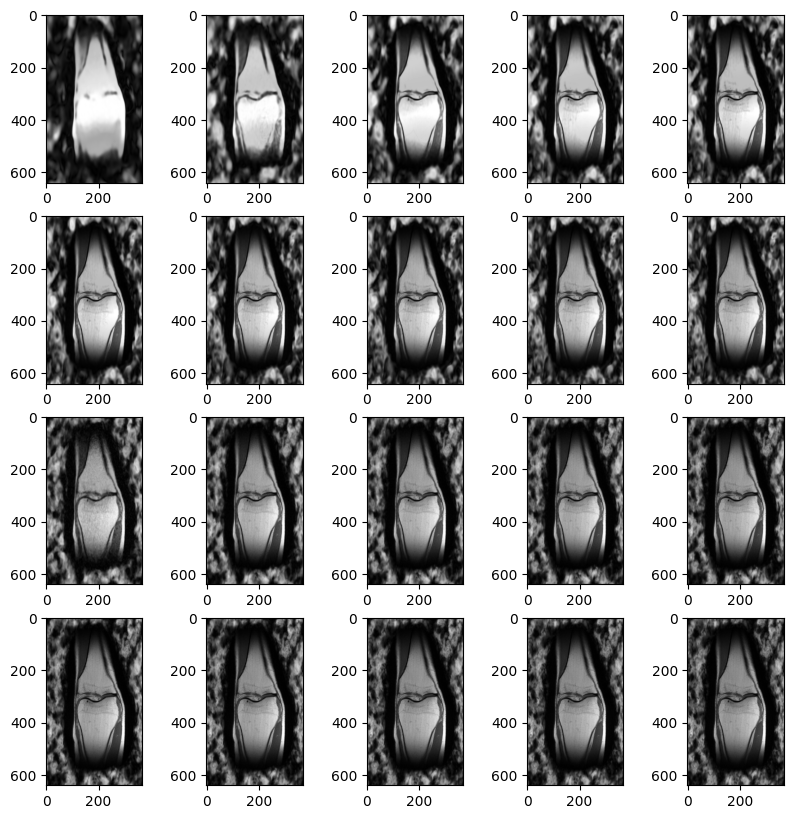

In [26]:
'''import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
for i, image in enumerate(image_list_SIREN):
    axs[i // 5, i % 5].imshow(complex_abs(image), cmap="gray")'''

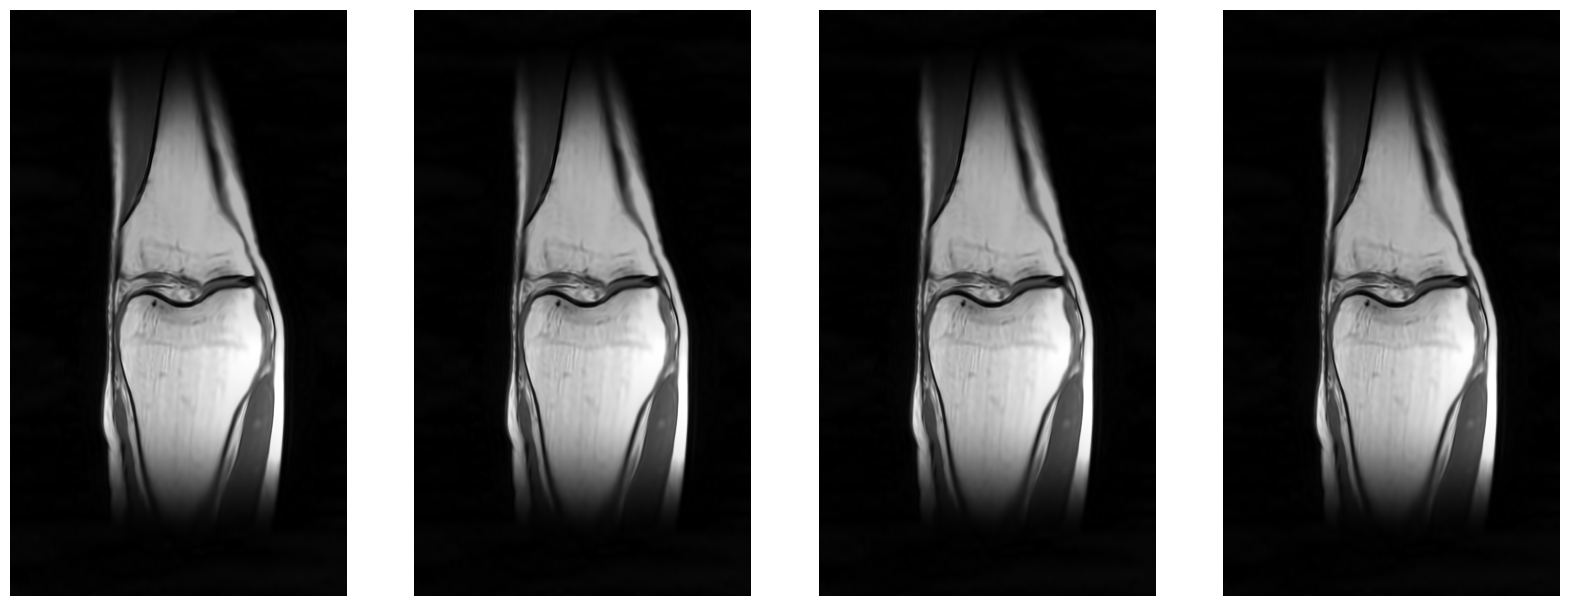

In [83]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list_SIREN[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")  # , vmin=0, vmax=2)
    axs[i % 5].axis("off")

# The Ground Truth Image

In [84]:
reconstructModel=F_adj()
GroundTruth_Image=reconstructModel(kspace)
GroundTruth_Image.shape

torch.Size([15, 640, 368, 2])

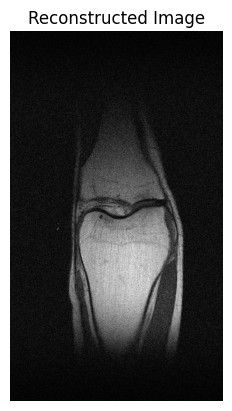

In [88]:
import matplotlib.pyplot as plt

# Assuming `reconstructed_image` is a complex-valued tensor or array
# and `complex_abs` is a function that computes the magnitude of complex data

# Calculate the absolute value (magnitude) of the reconstructed image for visualization
image_magnitude = complex_abs(GroundTruth_Image[8])

# Plot the image
plt.imshow(image_magnitude, cmap="gray")
plt.title("Reconstructed Image")
plt.axis('off')  # Optional: Removes the axis to emphasize the image
plt.show()


# PSNR, SSIM, NMSE, and NMI Alternative

In [89]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_mutual_information  as nmi
#https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity

In [90]:
# Assuming last images are ground truth and predicted images respectively
ground_truth_image=GroundTruth_Image[8]
predicted_image_ADAM = image_list_ADAM[-1]
predicted_image_SIREN = image_list_SIREN[-1]

# Clip and convert images to uint8 (Not sure which conversion is correct) or the one below
#gt_image_ADAM_np = np.clip(gt_image_ADAM_np, 0, 255).astype(np.uint8)
#predicted_image_SIREN_np = np.clip(predicted_image_SIREN_np, 0, 255).astype(np.uint8)


In [97]:
ground_truth_image.shape
predicted_image_ADAM.shape
predicted_image_SIREN.shape

torch.Size([640, 368, 2])

In [98]:

# Convert tensors to numpy arrays
gt_np=ground_truth_image.cpu().numpy()
pred_np_Adam = predicted_image_ADAM.cpu().numpy()
pred_np_Siren = predicted_image_SIREN.cpu().numpy()

# Rescale the values to [0, 255]
#gt_np = ((gt_np - gt_np.min()) / (gt_np.max() - gt_np.min()) ).astype(np.uint8)
#pred_np = ((pred_np - pred_np.min()) / (pred_np.max() - pred_np.min()) * 255).astype(np.uint8)

# Convert to grayscale if necessary
#gt_gray = np.mean(gt_np, axis=2)#I don't think it's converting the image to gray scale
#pred_gray = np.mean(pred_np, axis=2)

#By taking the mean across the color channels, this method essentially converts the color image into grayscale by preserving the luminance information. Each pixel in the resulting grayscale image represents the average intensity of the corresponding pixel in the original color image.

# Calculate PSNR
#psnr_value = psnr(gt_np, pred_np, data_range=255)
psnr_value = psnr(gt_np, pred_np_Siren)
#psnr_value = psnr(gt_gray, pred_gray, data_range=255)


# Calculate NRMSE
nrmse_value = nrmse(gt_np, pred_np_Siren)
#nrmse_value = nrmse(gt_gray, pred_gray)

# Calculate SSIM
ssim_value, ssim_map = ssim(gt_np, pred_np_Siren,channel_axis=2,full=True)
#ssim_value, ssim_map = ssim(gt_gray, pred_gray, data_range=255,full=True)
#ssim_value, ssim_map = ssim(gt_np, pred_np,data_range=255,channel_axis=2,full=True)

# Calculate normalized mutual information
nmi_value = nmi(gt_np, pred_np_Siren, bins=100)



print("PSNR:", psnr_value)
print("NRMSE:", nrmse_value)
print("SSIM:", ssim_value)
print("SSIM Map:", ssim_map)
print("Normalized Mutual Information:", nmi_value)


ValueError: image_true has intensity values outside the range expected for its data type. Please manually specify the data_range.

In [82]:
num_channels = gt_np.shape[2]
#num_channels = gt_image_ADAM.shape[2]
print("Number of color channels:", num_channels)

Number of color channels: 2


# CGM Rough (Not Final)

In [ ]:
import sigpy as sp
from sigpy.alg import ConjugateGradient

# Define the A matrix (sensitivity matrix), masked k-space data (b), and initial guess (x)
A = csm  # Assuming csm is the sensitivity matrix
b = masked_kspace  # Assuming masked k-space is the observed data
x = torch.zeros_like(b)  # Initial guess (you can provide your own initial guess if available)

# Define the Conjugate Gradient reconstruction function
def reconstruct_mri(A, b, x):
    cg = ConjugateGradient(A=A, b=b, x=x, max_iter=100, tol=0)  # Create the ConjugateGradient object
    reconstructed_image = cg.run()  # Run the Conjugate Gradient algorithm
    return reconstructed_image

# Reconstruct MRI
reconstructed_image = reconstruct_mri(A, b, x)

# Show the reconstructed image (assuming it's a torch tensor)
# You may need to adjust the dimensions and format of the reconstructed image
# to be suitable for display depending on your specific data
# For example, you can convert it to a numpy array and then display it using matplotlib
import matplotlib.pyplot as plt
import numpy as np

reconstructed_image_np = reconstructed_image.numpy()  # Convert to numpy array if necessary
plt.imshow(np.abs(reconstructed_image_np), cmap='gray')  # Assuming magnitude image for display
plt.axis('off')
plt.title('Reconstructed MRI')
plt.show()
